# README
1. 需要修改的地方
  - project_dir: 更改为自己的Google Drive内的文件夹路径，该文件夹内请创建
    - /data: 用于存放训练数据
    - /checkpoints: 用于存放保存模型
  - PARAMS: 更改自己需要的参数配置

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
# your user last_name dir, wu/xu/xie/cui
USER = "wu"

if USER == "":
  raise ValueError("name should not be empty, should in xu/wu/xie/cui")

In [ ]:
import json

def read_json(json_path):
  with open(json_path, 'r' ,encoding='utf-8') as rf:
    return json.load(rf)

def save_json(json_path, data):
  with open(json_path, 'w', encoding='utf-8') as wf:
    json.dump(data, wf)

In [ ]:
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# your 5018 project directory, used to save model checkpoints and datasets
project_dir = os.path.join('/content/drive/MyDrive/', './5018Group')

In [ ]:
# all parameters required here
strategy = 2
PARAMS = {
    "STRATEGY": strategy,
    "MAX_TOKEN_COUNT": 128, # our max text length is 90, so 128 may be enough
    "TRAINING_DATAPATH": os.path.join(project_dir, "./data/training.csv"),  # training data path
    "VALIDATION_DATAPATH": os.path.join(project_dir, "./data/validation.csv"),  # validation data path
    "TEST_DATAPATH": os.path.join(project_dir, "./data/test.csv"),  # test data path
    "TEST_nah_DATAPATH": os.path.join(project_dir, "./data/test-nahjalbalagha.csv"),
    "BATCH_SIZE": 64, # batch size
    "NUM_TRAIN_WORKERS": 4, # parallel workers for training
    "NUM_VAL_WORKERS": 4,  # parallel workers for validation
    "LEARNING_RATE": 1.5e-6, 
    "LOSS_RATIO": 0.73, #0.68,
    "NUM_EPOCHES": 40, 
    "CHECKPOINT_PATH": os.path.join(project_dir, f'./checkpoints/{USER}/resbert{strategy}.pt'),
    "SCORE_PATH": os.path.join(project_dir, f'./checkpoints/{USER}/score{strategy}.json'),
    "THRESHOLD": 0.25 
}

In [ ]:
print(PARAMS)

{'STRATEGY': 2, 'MAX_TOKEN_COUNT': 128, 'TRAINING_DATAPATH': '/content/drive/MyDrive/./5018Group/./data/training.csv', 'VALIDATION_DATAPATH': '/content/drive/MyDrive/./5018Group/./data/validation.csv', 'TEST_DATAPATH': '/content/drive/MyDrive/./5018Group/./data/test.csv', 'TEST_nah_DATAPATH': '/content/drive/MyDrive/./5018Group/./data/test-nahjalbalagha.csv', 'BATCH_SIZE': 16, 'NUM_TRAIN_WORKERS': 4, 'NUM_VAL_WORKERS': 4, 'LEARNING_RATE': 1.5e-06, 'LOSS_RATIO': 0.73, 'NUM_EPOCHES': 40, 'CHECKPOINT_PATH': '/content/drive/MyDrive/./5018Group/./checkpoints/wu/resbert2.pt', 'SCORE_PATH': '/content/drive/MyDrive/./5018Group/./checkpoints/wu/score2.json', 'THRESHOLD': 0.25}


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
import torch

from sklearn.model_selection import train_test_split

In [ ]:
tokenizer =  AutoTokenizer.from_pretrained("tum-nlp/Deberta_Human_Value_Detector")


tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

In [ ]:
# check whether can use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device type is {device}')

device type is cuda


In [ ]:
# our model based on Adam Smith
class ResBERT(nn.Module):
  def __init__(self, strategy=1):
    super().__init__()

    # debert module used by adam smith team
    self.bert = AutoModelForSequenceClassification.from_pretrained("tum-nlp/Deberta_Human_Value_Detector", trust_remote_code=True).bert

    self._strategy_mode = strategy
    # default hidden size
    self._hidden_size = 20 + 54
    if self._strategy_mode not in [1,2]:
      raise ValueError("Invalid strategy, please check!")
    elif self._strategy_mode == 2:
      self._hidden_size = self.bert.config.hidden_size + 54


    # linear function to get final 54 level-1 predictions
    self.level1classifier = nn.Linear(self.bert.config.hidden_size,54) #, bias=True)

    # linear function to get temporary 20 category predictions
    self.temp_category_classifier = nn.Linear(self.bert.config.hidden_size, 20) #, bias=True)
    # linear function to get final 20 category predictions
    self.final_category_classifier = nn.Linear(self._hidden_size, 20) #, bias=True)
    # activarion function
    self.activate = nn.LeakyReLU(0.2)#nn.ReLU()

    self.norm = nn.LayerNorm(54)

    # self.criterion = nn.BCEWithLogitsLoss()


  def forward(self, input_ids, attention_mask):
    # return BaseModel('last_hidden_state':[batch_size,seq_size,hidden_size]) tensor
    bert_feature = self.bert(input_ids, attention_mask)

    cls_embd = self._cls_embeddings(bert_feature)

    # get final output
    cls = self._strategy(cls_embd)

    output = torch.sigmoid(cls)

    return output


  def _cls_embeddings(self, output):
    '''Returns the embeddings corresponding to the <CLS> token of each text. '''
    return output.last_hidden_state[:,0]


  def _strategy(self, output):
    if self._strategy_mode == 1:
      return self._strategy1(output)
    return self._strategy2(output)


  def _strategy1(self, output):
    # get level 1 categories classification, final output
    level1 = self.level1classifier(output)

    # get temporary categories classification
    temp_category = self.temp_category_classifier(output)

    # activate level-1 as non-linear parameters for final prediction
    extra_level1 = self.activate(level1)
    # activate temporary categories as non-linear parameters for final prediction
    # can be omit
    temp_category = self.activate(temp_category)

    # concate temporary categories and level 1 categories
    hier_category = torch.cat((temp_category, extra_level1), 1)

    # get final category prediction output
    category = self.final_category_classifier(hier_category)

    output = torch.cat((category, level1), 1)

    return output

  def _strategy2(self, output):
    # get level 1 categories classification, final output
    level1 = self.level1classifier(output)

    # activate level-1 as non-linear parameters for final prediction
    extra_level1 = self.norm(level1)
    extra_level1 = self.activate(extra_level1)

    hier_category = torch.cat((output, extra_level1), 1)

    # get final category prediction output
    category = self.final_category_classifier(hier_category)

    output = torch.cat((category, level1), 1)

    return output


In [ ]:
# instance our model using the strategy
model = ResBERT(strategy=PARAMS["STRATEGY"])
model = model.to(device)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

configuration_deberta_arg_classifier.py:   0%|          | 0.00/199 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tum-nlp/Deberta_Human_Value_Detector:
- configuration_deberta_arg_classifier.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deberta_arg_classifier.py:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tum-nlp/Deberta_Human_Value_Detector:
- modeling_deberta_arg_classifier.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
print(f'use the strategy {PARAMS["STRATEGY"]}')
try:
  model.load_state_dict(torch.load(PARAMS["CHECKPOINT_PATH"]), strict=False)
  print("load checkpoint successfully")
except FileNotFoundError:
  print("init with no checkpoint")

use the strategy 2
load checkpoint successfully


In [ ]:
layer2freeze = [] #["bert"]
for name, child in model.named_children():
  if name not in layer2freeze:
    for param in child.parameters():
      param.requires_grad = True
  else:
    for param in child.parameters():
      param.requires_grad = False


In [ ]:
# define custom dataset
class BertDataset(Dataset):
  def __init__(
      self,
      data: pd.DataFrame,
      tokenizer,
      max_token_count=PARAMS["MAX_TOKEN_COUNT"],
      ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_count
    self.label_columns = self.data.columns.tolist()[4:]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row.Combined

    labels = data_row[self.label_columns]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        text=text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels)
      )

In [ ]:
train_data_path = PARAMS["TRAINING_DATAPATH"]

train_df = pd.read_csv(train_data_path, index_col=0)

validation_path_path = PARAMS["VALIDATION_DATAPATH"]

validation_df = pd.read_csv(validation_path_path, index_col=0)

In [ ]:
value_level2 = train_df.loc[:, "Self-direction: thought":]
value_level2[value_level2["Face"] == 1].loc[:, "Be creative":].sum(axis=1)


Argument ID
A01011    6
A02003    4
A04016    2
A05022    6
A05058    5
         ..
E07258    5
E07264    3
E07270    4
E07277    5
E07278    5
Length: 382, dtype: int64

In [ ]:
# train_df, validation_df = train_test_split(train_data, test_size=PARAMS["TEST_SIZE"])

train_dataset = BertDataset(data = train_df, tokenizer=tokenizer)
validation_dataset = BertDataset(data=validation_df, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, num_workers=PARAMS["NUM_TRAIN_WORKERS"])
validation_dataloader = DataLoader(validation_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, num_workers=PARAMS["NUM_VAL_WORKERS"])

print(f'training dataset size is {len(train_dataloader.dataset)}\nvalidation dataset size is {len(validation_dataloader.dataset)}')

training dataset size is 5393
validation dataset size is 1896


In [ ]:
from torchmetrics import F1Score, Recall, Precision, Accuracy
from sklearn.metrics import classification_report

In [ ]:
# loss function, we default use BCE
from torch.optim import AdamW
criterion = nn.BCEWithLogitsLoss()
f1score = F1Score(num_labels=74, threshold=PARAMS["THRESHOLD"], average="macro", task="multilabel").to(device)
f1score20 = F1Score(num_labels=20, threshold=PARAMS["THRESHOLD"], average="macro", task="multilabel").to(device)

recall = Recall(num_labels=74, threshold=PARAMS["THRESHOLD"], average="macro", task="multilabel").to(device)
precision = Precision(num_labels=74, threshold=PARAMS["THRESHOLD"], average="macro", task="multilabel").to(device)
accuracy = Accuracy(num_labels=74, threshold=PARAMS["THRESHOLD"], average="macro", task="multilabel").to(device)

# optimizer function, we default use adam
optimizer = AdamW(model.parameters(), lr=PARAMS["LEARNING_RATE"])


In [ ]:
def calculate_f1_score20(predicts, labels):
  predicts = predicts[:,:20]
  labels = labels[:,:20]
  return f1score20(predicts, labels)

In [ ]:
upper, lower = 1, 0
category_label_numbers = train_df.columns.tolist()[4:24]
all_label_numbers = train_df.columns.tolist()[4:]

In [ ]:
f1_score = """precision    recall  f1-score   support

   Self-direction: thought       1.00      0.89      0.94       988
    Self-direction: action       1.00      0.92      0.96      1395
               Stimulation       0.00      0.00      0.00       247
                  Hedonism       0.00      0.00      0.00       172
               Achievement       0.99      0.94      0.97      1512
          Power: dominance       0.00      0.00      0.00       610
          Power: resources       0.00      0.00      0.00       625
                      Face       0.00      0.00      0.00       382
        Security: personal       0.99      0.94      0.96      2000
        Security: societal       0.99      0.95      0.97      1728
                 Tradition       0.00      0.00      0.00       568
         Conformity: rules       0.99      0.83      0.90      1177
 Conformity: interpersonal       0.00      0.00      0.00       207
                  Humility       0.00      0.00      0.00       395
       Benevolence: caring       0.00      0.00      0.00      1332
Benevolence: dependability       0.00      0.00      0.00       806
     Universalism: concern       0.99      0.95      0.97      2081
      Universalism: nature       1.00      0.89      0.94       427
   Universalism: tolerance       0.00      0.00      0.00       664
 Universalism: objectivity       0.00      0.00      0.00      1054

                 micro avg       0.99      0.57      0.72     18370
                 macro avg       0.40      0.37      0.38     18370
              weighted avg       0.61      0.57      0.59     18370
               samples avg       0.95      0.61      0.71     18370
"""
def get_f1(f1_score):
  texts = f1_score.split("\n")
  #print(f'first line is {texts[2]}')
  concrete = texts[2:22]
  macro_avg = texts[24]

  zeros = 0
  for text in concrete:
    argu = [i for i in text.split(" ") if i != ""]
    f1 = argu[-2]
    if float(f1) == 0:
      zeros += 1

  macro_avg_argu = [i for i in macro_avg.split(" ") if i != ""]
  macro_avg_f1 = macro_avg_argu[-2]

  # print(f'zero count={zeros}')
  # print(f'f1 score={macro_avg_f1}')

  return macro_avg_f1, zeros

# get_f1(f1_score)

In [ ]:
# define train step
def train(model, dataloader, loss_fn, optimizer, f1_reg, loss_ratio=PARAMS["LOSS_RATIO"]):

  f1_reg = torch.tensor(float(f1_reg))

  size = len(dataloader.dataset)
  model.train()

  total_loss, total_accuracy = 0.0, 0.0

  print(f'total batch {len(dataloader)}, batch_size {PARAMS["BATCH_SIZE"]}, start with f1 reg {f1_reg}')

  epoch_preds, epoch_labels = [], []

  for i, batch in enumerate(dataloader):
    input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

    predict = model(input_ids, attention_mask)

    epoch_labels.extend(labels.detach().cpu().numpy())
    epoch_preds.extend(predict.detach().cpu().numpy())

    if loss_ratio is None:
      loss = loss_fn(predict, labels)
    else:
      loss1 = loss_fn(predict[:,:20], labels[:,:20])
      loss2 = loss_fn(predict[:,20:], labels[:,20:])
      loss = loss1 * loss_ratio + loss2 * (1-loss_ratio)

    f1 = f1score(predict, labels)
    f1_20 = calculate_f1_score20(predict, labels)
    acc = accuracy(predict, labels)

    loss_v1 = loss - f1_reg
    loss_v1.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()
    # total_f1 += f1.item()
    # total_f1_20 += f1_20.item()
    total_accuracy += acc.item()

    if i % 10 == 0:
      current = (i + 1) * PARAMS["BATCH_SIZE"]
      print(f"loss: {loss:>7f}, f1: {f1:>7f}, f1(20): {f1_20:>7f} accuracy: {acc:>7f}  [{current:>5d}/{size:>5d}]")

  avg_loss = total_loss * 1.0 / len(dataloader)
  # avg_f1 = total_f1 * 1.0 / len(dataloader)
  # avg_f1_20 = total_f1_20 * 1.0 / len(dataloader)
  avg_accuracy = total_accuracy * 1.0 / len(dataloader)

  epoch_preds = np.array(epoch_preds)
  epoch_labels = np.array(epoch_labels)

  y_pred = np.where(epoch_preds > PARAMS["THRESHOLD"], upper, lower)

  print("20 CATEGORY F1")
  cr = classification_report(
    epoch_labels[:,:20],
    y_pred[:,:20],
    target_names=category_label_numbers,
    zero_division=0,
  )
  print(cr)
  f1_reg, _ = get_f1(cr)
  f1_reg = float(f1_reg)
  print(f'next epoch f1 regularization is {f1_reg}')

  print("20 CATEGORY + 54 LEVEL 1 F1")
  print(classification_report(
    epoch_labels,
    y_pred,
    target_names=all_label_numbers,
    zero_division=0,
  ))

  epoch_f1 = f1score20(torch.tensor(epoch_preds[:,:20]).to(device), torch.tensor(epoch_labels[:,:20]).to(device)).item()

  print(f'---training avg loss {avg_loss}, f1(20) is {epoch_f1}, avg accuracy {avg_accuracy}')
  return avg_loss, epoch_f1, avg_accuracy, f1_reg

In [ ]:
torch.tensor(float("1.2"))

tensor(1.2000)

In [ ]:
# define validation step
def validation(model, dataloader, loss_fn, loss_ratio=PARAMS["LOSS_RATIO"]):
  model.eval()

  total_loss, total_accuracy = 0.0, 0.0
  valid_epoch_preds, valid_epoch_labels = [], []
  for i, batch in enumerate(dataloader):
    # if i % 20 == 0 and i != 0:
    #   print(f'batch {i} of {len(dataloader)}')
    input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
    with torch.no_grad():
      predict = model(input_ids, attention_mask)

      valid_epoch_preds.extend(predict.detach().cpu().numpy())
      valid_epoch_labels.extend(labels.detach().cpu().numpy())

      if loss_ratio is None:
        loss = loss_fn(predict, labels)
      else:
        loss1 = loss_fn(predict[:,:20], labels[:,:20])
        loss2 = loss_fn(predict[:,20:], labels[:,20:])
        loss = loss1 * loss_ratio + loss2 * (1-loss_ratio)

      # loss -= f1_reg
      # f1 = f1score(predict, labels)
      # f1_20 = calculate_f1_score20(predict, labels)
      acc = accuracy(predict, labels)

      total_loss += loss.item()
      # total_f1 += f1.item()
      # total_f1_20 += f1_20.item()
      total_accuracy += acc.item()

  avg_loss = total_loss * 1.0 / len(dataloader)
  # avg_f1 = total_f1 * 1.0 / len(dataloader)
  # avg_f1_20 = total_f1_20 * 1.0 / len(dataloader)
  avg_accuracy = total_accuracy * 1.0 / len(dataloader)

  valid_epoch_preds = np.array(valid_epoch_preds)
  valid_epoch_labels = np.array(valid_epoch_labels)

  valid_y_pred = np.where(valid_epoch_preds > PARAMS["THRESHOLD"], upper, lower)

  print("VALIDATION 20 CATEGORY F1")
  print(classification_report(
    valid_epoch_labels[:,:20],
    valid_y_pred[:,:20],
    target_names=category_label_numbers,
    zero_division=0,
  ))

  print("VALIDATION 20 CATEGORY + 54 LEVEL 1 F1")
  print(classification_report(
    valid_epoch_labels,
    valid_y_pred,
    target_names=all_label_numbers,
    zero_division=0,
  ))

  valid_epoch_f1 = f1score20(torch.tensor(valid_epoch_preds[:,:20]).to(device), torch.tensor(valid_epoch_labels[:,:20]).to(device)).item()

  print(f'---validation avg loss is {avg_loss}, f1(20) is {valid_epoch_f1}, avg accuracy is {avg_accuracy}')

  return avg_loss, valid_epoch_f1, avg_accuracy

In [ ]:
# set initial loss to infinite
try:
  score_v1 = read_json(PARAMS["SCORE_PATH"])
  #best_valid_loss = float(score["loss"])
  best_valid_f1 = float(score_v1["f1"])
  f1_reg = best_valid_f1
  print(f"last best trained f1 score info is {best_valid_f1}, f1 reg {f1_reg}.")
except FileNotFoundError:
  print("not find any train loss info")
  #best_valid_loss = float('inf')
  best_valid_f1 = -1
  second_valid_f1 = -1

# trace training loss and validation loss
train_loss_tracer, validation_loss_tracer = [], []
#train_f1_tracer, validation_f1_tracer = [], []
train_f1_20_tracer, validation_f1_20_tracer = [], []
train_acc_tracer, validation_acc_tracer = [], []
# start training
for epcoh in range(PARAMS["NUM_EPOCHES"]):
  print(f'>>> current is epoch {epcoh + 1}')
  train_loss, train_f1_20, train_acc, f1_reg = train(model, train_dataloader, criterion, optimizer, f1_reg)
  train_loss_tracer.append(train_loss)
  # train_f1_tracer.append(train_f1)
  train_f1_20_tracer.append(train_f1_20)
  train_acc_tracer.append(train_acc)
  validation_loss, validation_f1_20, validation_acc = validation(model, validation_dataloader, criterion)
  validation_loss_tracer.append(validation_loss)
  # validation_f1_tracer.append(validation_f1)
  validation_f1_20_tracer.append(validation_f1_20)
  validation_acc_tracer.append(validation_acc)
  if validation_f1_20 > best_valid_f1:
    torch.save(model.state_dict(), PARAMS["CHECKPOINT_PATH"])
    best_valid_f1 = validation_f1_20
    save_json(PARAMS["SCORE_PATH"], {
        "loss": validation_loss,
        "f1": validation_f1_20,
        "acc": validation_acc
    })
    print(f"___save model to {PARAMS['CHECKPOINT_PATH']} at epoch {epcoh + 1}")

Streaming output truncated to the last 5000 lines.
---validation avg loss is 0.6748231424003088, f1(20) is 0.6056952476501465, avg accuracy is 0.9288269426642346
___save model to /content/drive/MyDrive/./5018Group/./checkpoints/wu/resbert2.pt at epoch 21
>>> current is epoch 22
total batch 338, batch_size 16, start with f1 reg 0.7900000214576721
loss: 0.648160, f1: 0.341121, f1(20): 0.618037 accuracy: 0.940878  [   16/ 5393]
loss: 0.654159, f1: 0.339635, f1(20): 0.626154 accuracy: 0.964527  [  176/ 5393]
loss: 0.651143, f1: 0.424324, f1(20): 0.783333 accuracy: 0.977196  [  336/ 5393]
loss: 0.653957, f1: 0.382357, f1(20): 0.687778 accuracy: 0.961993  [  496/ 5393]
loss: 0.642134, f1: 0.350610, f1(20): 0.614502 accuracy: 0.951014  [  656/ 5393]
loss: 0.660210, f1: 0.391248, f1(20): 0.701667 accuracy: 0.953547  [  816/ 5393]
loss: 0.648572, f1: 0.382325, f1(20): 0.661746 accuracy: 0.961149  [  976/ 5393]
loss: 0.645254, f1: 0.402436, f1(20): 0.769490 accuracy: 0.956926  [ 1136/ 5393]
loss

In [ ]:
test_data_path = PARAMS["TEST_DATAPATH"]

test_df = pd.read_csv(test_data_path, index_col=0)
test_dataset = BertDataset(data=test_df, tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, num_workers=PARAMS["NUM_VAL_WORKERS"])

model = ResBERT(strategy=PARAMS["STRATEGY"])
model = model.to(device)

print(f'use the strategy {PARAMS["STRATEGY"]}')
try:
  model.load_state_dict(torch.load(PARAMS["CHECKPOINT_PATH"]))
  print("load checkpoint successfully")
except FileNotFoundError:
  print("init with no checkpoint")

test_loss, test_f1_20, test_acc = validation(model, test_dataloader, criterion)

use the strategy 2
load checkpoint successfully
VALIDATION 20 CATEGORY F1
                            precision    recall  f1-score   support

   Self-direction: thought       0.59      0.59      0.59       143
    Self-direction: action       0.69      0.69      0.69       391
               Stimulation       0.41      0.14      0.21        77
                  Hedonism       0.21      0.19      0.20        26
               Achievement       0.62      0.64      0.63       412
          Power: dominance       0.00      0.00      0.00       108
          Power: resources       0.46      0.55      0.50       105
                      Face       0.00      0.00      0.00        96
        Security: personal       0.75      0.79      0.77       537
        Security: societal       0.57      0.70      0.62       397
                 Tradition       0.48      0.57      0.52       168
         Conformity: rules       0.63      0.55      0.59       287
 Conformity: interpersonal       0.68    

In [ ]:
import matplotlib.pyplot as plt

def draw(train, validation, title, y_label):
  plt.figure()
  plt.title(title)
  plt.xlabel('epoches')
  plt.ylabel(y_label)
  plt.plot(train, label=f'train {y_label}')
  plt.plot(validation, label=f'validation {y_label}')
  plt.legend()
  plt.show()

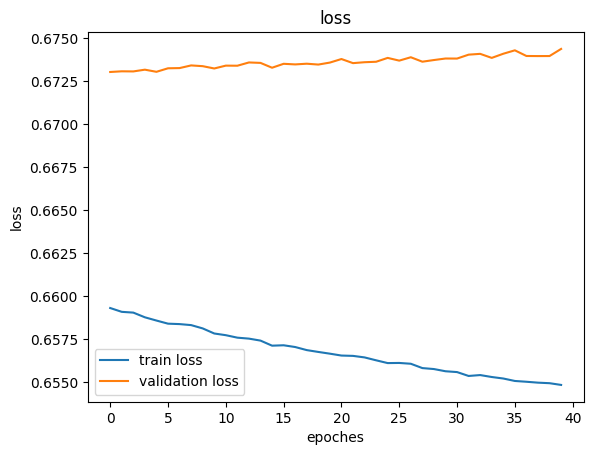

In [ ]:
draw(train_loss_tracer, validation_loss_tracer, "loss", 'loss')

In [ ]:
draw(train_f1_20_tracer, validation_f1_20_tracer, "f1(20) score", 'f1(20) score')

In [ ]:
# redefine validation step to get the threshold that maximize f1
def validation(model, dataloader, loss_fn, loss_ratio=PARAMS["LOSS_RATIO"]):
  model.eval()

  total_loss, total_accuracy = 0.0, 0.0
  valid_epoch_preds, valid_epoch_labels = [], []
  for i, batch in enumerate(dataloader):
    input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
    with torch.no_grad():
      predict = model(input_ids, attention_mask)

      valid_epoch_preds.extend(predict.detach().cpu().numpy())
      valid_epoch_labels.extend(labels.detach().cpu().numpy())

      if loss_ratio is None:
        loss = loss_fn(predict, labels)
      else:
        loss1 = loss_fn(predict[:,:20], labels[:,:20])
        loss2 = loss_fn(predict[:,20:], labels[:,20:])
        loss = loss1 * loss_ratio + loss2 * (1-loss_ratio)

      # loss -= f1_reg
      # f1 = f1score(predict, labels)
      # f1_20 = calculate_f1_score20(predict, labels)
      acc = accuracy(predict, labels)

      total_loss += loss.item()
      # total_f1 += f1.item()
      # total_f1_20 += f1_20.item()
      total_accuracy += acc.item()

  avg_loss = total_loss * 1.0 / len(dataloader)
  # avg_f1 = total_f1 * 1.0 / len(dataloader)
  # avg_f1_20 = total_f1_20 * 1.0 / len(dataloader)
  avg_accuracy = total_accuracy * 1.0 / len(dataloader)

  valid_epoch_preds = np.array(valid_epoch_preds)
  valid_epoch_labels = np.array(valid_epoch_labels)
  best_f1 = 0
  best_threshold = []
  for i in range(0, 30, 1):
    i = i / 100.0
    valid_y_pred = np.where(valid_epoch_preds > i, upper, lower)
    cr = classification_report(
      valid_epoch_labels[:,:20],
      valid_y_pred[:,:20],
      target_names=category_label_numbers,
      zero_division=0,
    )
    print(cr)
    temp_f1, _ = get_f1(cr)
    temp_f1 = float(temp_f1)
    if temp_f1 >= best_f1:
      if temp_f1 == best_f1:
        best_threshold.append(i)
      best_f1 = temp_f1


  print(f"-------threshold is:{best_threshold}, f1 is:{best_f1}")

  valid_epoch_f1 = f1score20(torch.tensor(valid_epoch_preds[:,:20]).to(device), torch.tensor(valid_epoch_labels[:,:20]).to(device)).item()

  print(f'---validation avg loss is {avg_loss}, f1(20) is {valid_epoch_f1}, avg accuracy is {avg_accuracy}')

  return avg_loss, valid_epoch_f1, avg_accuracy

In [ ]:
# get the threshold that maximize f1
model = ResBERT(strategy=PARAMS["STRATEGY"])
model = model.to(device)
model.load_state_dict(torch.load(PARAMS["CHECKPOINT_PATH"]))
validation_loss, validation_f1_20, validation_acc = validation(model, validation_dataloader, criterion)

                            precision    recall  f1-score   support

   Self-direction: thought       0.13      1.00      0.23       251
    Self-direction: action       0.26      1.00      0.41       496
               Stimulation       0.07      1.00      0.14       138
                  Hedonism       0.05      1.00      0.10       103
               Achievement       0.30      1.00      0.47       575
          Power: dominance       0.09      1.00      0.16       164
          Power: resources       0.07      1.00      0.13       132
                      Face       0.07      1.00      0.13       130
        Security: personal       0.40      1.00      0.57       759
        Security: societal       0.26      1.00      0.41       488
                 Tradition       0.09      1.00      0.17       172
         Conformity: rules       0.24      1.00      0.39       455
 Conformity: interpersonal       0.03      1.00      0.06        60
                  Humility       0.07      1.00

In [ ]:
test_data_path = PARAMS["TEST_DATAPATH"]

test_df = pd.read_csv(test_data_path, index_col=0)
test_dataset = BertDataset(data=test_df, tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, num_workers=PARAMS["NUM_VAL_WORKERS"])

model = ResBERT(strategy=PARAMS["STRATEGY"])
model = model.to(device)

print(f'use the strategy {PARAMS["STRATEGY"]}')
try:
  model.load_state_dict(torch.load(PARAMS["CHECKPOINT_PATH"]))
  print("load checkpoint successfully")
except FileNotFoundError:
  print("init with no checkpoint")

test_loss, test_f1_20, test_acc = validation(model, test_dataloader, criterion)

In [ ]:
test_data_path = PARAMS["TEST_nah_DATAPATH"]

test_df = pd.read_csv(test_data_path, index_col=0)
test_dataset = BertDataset(data=test_df, tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, num_workers=PARAMS["NUM_VAL_WORKERS"])

model = ResBERT(strategy=PARAMS["STRATEGY"])
model = model.to(device)

print(f'use the strategy {PARAMS["STRATEGY"]}')
try:
  model.load_state_dict(torch.load(PARAMS["CHECKPOINT_PATH"]))
  print("load checkpoint successfully")
except FileNotFoundError:
  print("init with no checkpoint")

test_loss, test_f1_20, test_acc = validation(model, test_dataloader, criterion)